# Examples


In [6]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogLocator

from src.bearing_calculations import solve_eccentricity, solve_K_and_C, solve_dynamic_K_and_C

# sns.set_context("notebook", font_scale=1.2)
# sns.set_theme(style="whitegrid")
# sns.set_palette("husl")

## Task 1

Calculate K and C matrixes for fluid bearing (journal/tilting pad)

### Friswell example 5.5


In [7]:
# Given parameters
D = 100  # mm, diameter
L = 30  # mm, length
f = 525  # N, static load
c = 0.1  # mm, radial clearance
omega = 1500  # rpm, rotational speed
eta = 0.1  # Pa.s, viscosity

# Necessary unit conversions
D = D / 1000  # Convert mm to m
L = L / 1000  # Convert mm to m
c = c / 1000  # Convert mm to m
omega = omega * (2 * np.pi) / 60  # Convert rpm to rad/s

epsilon = solve_eccentricity(D, omega, eta, L, f, c)
print("Eccentricity (epsilon):", epsilon)

K, C = solve_K_and_C(omega, f, c, epsilon)

print()
print("Stiffness matrix K (N/m):")
print(K)

print()
print("Damping matrix C (Ns/m):")
print(C)

Eccentricity (epsilon): 0.26629750900547666

Stiffness matrix K (N/m):
[[ 12807959.57740874  16393593.2486744 ]
 [-25060393.27644924   8815302.74116861]]

Damping matrix C (Ns/m):
[[232896.92986658 -81924.37052422]
 [-81924.37052422 294911.61944048]]


In [8]:
# Book answers are in MN/m and kNs/m

print()
print("Stiffness matrix K (MN/m):")
print(K / 1e6)

print()
print("Damping matrix C (kNs/m):")
print(C / 1e3)


Stiffness matrix K (MN/m):
[[ 12.80795958  16.39359325]
 [-25.06039328   8.81530274]]

Damping matrix C (kNs/m):
[[232.89692987 -81.92437052]
 [-81.92437052 294.91161944]]


### Al-Bender figures 9.5 and 9.6


In [9]:
# Helpers


def plot_dynamic_coeff(sigma_vals, vals, ylabel, ax):
    ax.semilogx(sigma_vals, vals)

    ax.set_ylabel(f"${ylabel}$")
    ax.set_xlabel("σ")

    # Major ticks
    ax.xaxis.set_major_locator(LogLocator(base=10))
    ax.grid(which="major", linestyle="-", color="gray", alpha=0.5)

    # Minor ticks
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs="auto"))
    ax.grid(which="minor", linestyle="--", color="lightgray", alpha=0.5)

    return ax

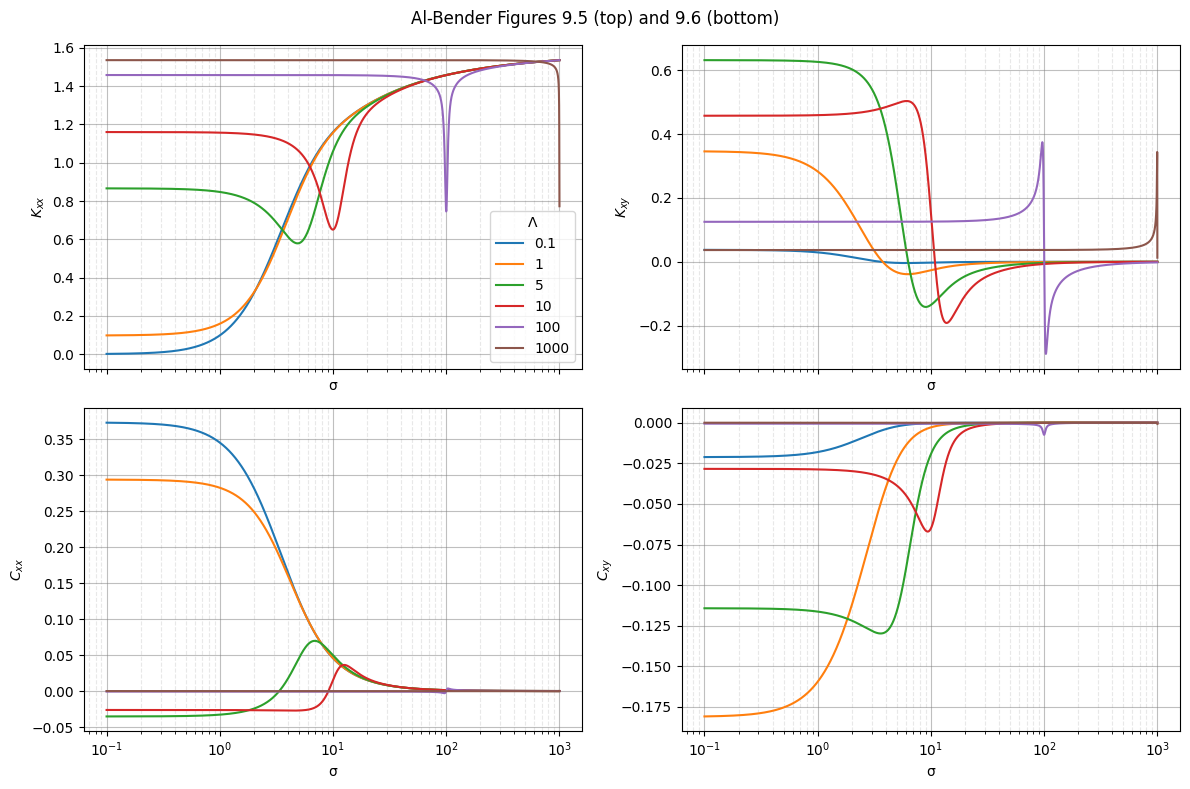

In [10]:
fig1, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
axs = axs.ravel()

lambda_vals = [0.1, 1, 5, 10, 100, 1000]
sigma_vals = np.logspace(-1, 3, 10000)
LD_ratio = 1

for lambda_ in lambda_vals:
    K, C = solve_dynamic_K_and_C(lambda_, sigma_vals, LD_ratio)

    K_xx = K[0, 0]
    K_xy = K[0, 1]
    C_xx = C[0, 0]
    C_xy = C[0, 1]

    plot_dynamic_coeff(sigma_vals, K_xx, "K_{xx}", axs[0])
    axs[0].legend(title="Λ", loc="lower right", labels=lambda_vals)
    plot_dynamic_coeff(sigma_vals, K_xy, "K_{xy}", axs[1])
    plot_dynamic_coeff(sigma_vals, C_xx, "C_{xx}", axs[2])
    plot_dynamic_coeff(sigma_vals, C_xy, "C_{xy}", axs[3])

plt.suptitle("Al-Bender Figures 9.5 (top) and 9.6 (bottom)")
plt.tight_layout()
plt.show()